# Assignment 4: Fine-Tuning do Segment Anything Model (SAM)  

**Introdução:**  
O Segment Anything Model (SAM) é um modelo de segmentação altamente versátil e poderoso, desenvolvido pela Meta AI. Ele foi projetado para lidar com uma ampla gama de tarefas, como segmentar objetos específicos, regiões ou até mesmo identificar múltiplos objetos em uma única imagem sem necessidade de treinamento adicional.  

O SAM utiliza uma abordagem baseada em *prompts*, permitindo que os usuários forneçam diferentes tipos de entrada, como pontos, caixas delimitadoras ou máscaras brutas, para guiar o modelo na segmentação desejada. Ele é composto por:  
- **Encoder de Imagem:** Extrai características visuais robustas.  
- **Encoder de Prompts:** Interpreta entradas do usuário.  
- **Mask Decoder:** Gera máscaras de segmentação com alta precisão.  

Apesar de ser altamente generalista, o SAM pode ser ajustado (fine-tuned) para melhorar seu desempenho em tarefas específicas. Este processo envolve utilizar dados especializados e adaptar o modelo às necessidades de aplicações como segmentação médica, agricultura, monitoramento ambiental, entre outras.  

**Objetivo:**  
Realizar o fine-tuning do SAM para uma tarefa de segmentação específica à sua escolha, demonstrando os passos e resultados por meio de uma apresentação de 10 minutos.  

**Instruções:**  

1. **Escolha da Tarefa:**  
   Selecione uma aplicação prática de segmentação para o fine-tuning do SAM, como:  
   - Segmentação de objetos em ambientes urbanos.  
   - Identificação de características em imagens médicas.  
   - Monitoramento de mudanças em imagens de satélite.  

2. **Preparação do Dataset:**  
   - Utilize ou construa um dataset relevante para sua tarefa.  
   - Divida os dados em treino, validação e teste.  
   - Aplique técnicas de *data augmentation* caso necessário.  

3. **Adaptação do SAM:**  
   - Use o SAM pré-treinado como base.  
   - Adapte sua arquitetura para atender aos requisitos da tarefa.  
   - Decida se congelará partes do modelo ou ajustará todas as camadas.  

4. **Treinamento:**  
   - Configure parâmetros como número de épocas, taxa de aprendizado e tamanho do batch.  
   - Utilize métricas adequadas (como IoU ou Dice Coefficient) para avaliar o desempenho do modelo ajustado.  

5. **Análise e Resultados:**  
   - Compare os resultados do modelo original (pré-treinado) com o modelo ajustado (fine-tuned).  
   - Destaque os desafios enfrentados e as soluções adotadas durante o fine-tuning.  

6. **Entrega:**  
   A entrega será feita por meio de um vídeo gravado de no máximo 10 minutos, contendo:  
   - Breve introdução ao SAM e à tarefa escolhida.  
   - Explicação sobre o dataset e adaptações feitas no modelo.  
   - Resultados e comparações entre o SAM original e o modelo ajustado.  
   - Conclusões e sugestões de melhorias ou aplicações futuras.  

**Dicas:**  
- Use a [documentação oficial do SAM](https://github.com/facebookresearch/segment-anything) como guia técnico.  
- Experimente congelar diferentes partes do modelo e observe como isso afeta o desempenho.  

## Tarefa: Segmentação de Buracos em Ruas

**Dataset**: Imagens de ruas com anotações de buracos
- **Treino**: Data Segmentation/train/
- **Validação**: Data Segmentation/valid/
- **Máscaras**: Geradas a partir de polígonos normalizados

**Objetivo**:
1. Avaliar SAM pré-treinado sem fine-tuning
2. Realizar fine-tuning do SAM para esta tarefa específica
3. Comparar resultados usando métricas IoU e Dice Coefficient

Pré-sets

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Copie sua pasta 'Data Segmentation' do Google Drive para o diretório atual do Colab
!cp -r "/content/drive/My Drive/Data Segmentation" "./Data Segmentation"

# Verifique se a pasta foi copiada com sucesso listando seu conteúdo
!ls -F "./Data Segmentation/train/images"

pic-100-_jpg.rf.17047bb032a49c96643c5f2108bb99dd.jpg
pic-100-_jpg.rf.8c9076ee84698f90f04765f4e794a819.jpg
pic-100-_jpg.rf.ebc3af260e989e6f9e1e9221b9dff6b0.jpg
pic-101-_jpg.rf.1e32a49f89a38974ded11bba8dd3e56b.jpg
pic-101-_jpg.rf.4abe48a3d2a5e556908bf4286446e5ce.jpg
pic-101-_jpg.rf.8380b58f6540ec91db66934b342f7f9e.jpg
pic-102-_jpg.rf.bb6db5bdb59d1a6af15b0a0b565a3cdb.jpg
pic-102-_jpg.rf.cd0b0b3a64e3a11005884c98c1f6c3aa.jpg
pic-102-_jpg.rf.df35bf045672f19a05f84a8c365dab3a.jpg
pic-103-_jpg.rf.26017e20e92320bcde575710389353b1.jpg
pic-103-_jpg.rf.4fa35472ae606aca56d49966dc91b5b6.jpg
pic-103-_jpg.rf.e204fd0f4f80094ec52c54c31ab06db0.jpg
pic-104-_jpg.rf.117ec7cfcc77d6e6f80130934b1d5aa1.jpg
pic-104-_jpg.rf.e4efc52e048da0b6918c135b1bd39962.jpg
pic-104-_jpg.rf.f986cb78d75fc164de95ac33c56d9474.jpg
pic-105-_jpg.rf.0b52d3fe11f0b249a5eb2f14a8f0a14f.jpg
pic-105-_jpg.rf.0ce0939aec2bb2ab235addf64d130914.jpg
pic-105-_jpg.rf.859bee21c8abeda9bc4ef41da6d2d0bf.jpg
pic-106-_jpg.rf.0cbfb7193cdb49723d65f538678e22

Após executar o comando acima, a pasta `Data Segmentation` e todo o seu conteúdo (incluindo `train/images`, `valid/images`, etc.) estarão disponíveis no diretório raiz do seu Colab, permitindo que o código subsequente (`f1fyQ5trBnVK`) encontre as imagens e máscaras.

In [1]:
# Instalação das dependências necessárias
!pip install segment-anything torch torchvision opencv-python matplotlib numpy tqdm

In [2]:
# Imports
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configuração do device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando device: {device}")

Usando device: cuda


In [6]:
# Dataset personalizado para carregar imagens e máscaras
class StreetHoleDataset(Dataset):
    def __init__(self, images_dir, masks_dir):
        self.images_dir = images_dir
        self.masks_dir = masks_dir

        # Listar todas as imagens
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png'))]
        self.image_files.sort()

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Carregar imagem
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Carregar máscara correspondente
        mask_name = img_name.rsplit('.', 1)[0] + '_mask.png'
        mask_path = os.path.join(self.masks_dir, mask_name)

        if os.path.exists(mask_path):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            # Binarizar a máscara
            mask = (mask > 127).astype(np.uint8)
        else:
            # Se não houver máscara, criar uma vazia
            mask = np.zeros(image.shape[:2], dtype=np.uint8)

        return {
            'image': image,
            'mask': mask,
            'filename': img_name
        }

# Criar datasets
train_dataset = StreetHoleDataset(
    images_dir='Data Segmentation/train/images',
    masks_dir='Data Segmentation/masks_train'
)

val_dataset = StreetHoleDataset(
    images_dir='Data Segmentation/valid/images',
    masks_dir='Data Segmentation/masks_valid'
)

print(f"Dataset de treino: {len(train_dataset)} imagens")
print(f"Dataset de validação: {len(val_dataset)} imagens")

Dataset de treino: 720 imagens
Dataset de validação: 60 imagens


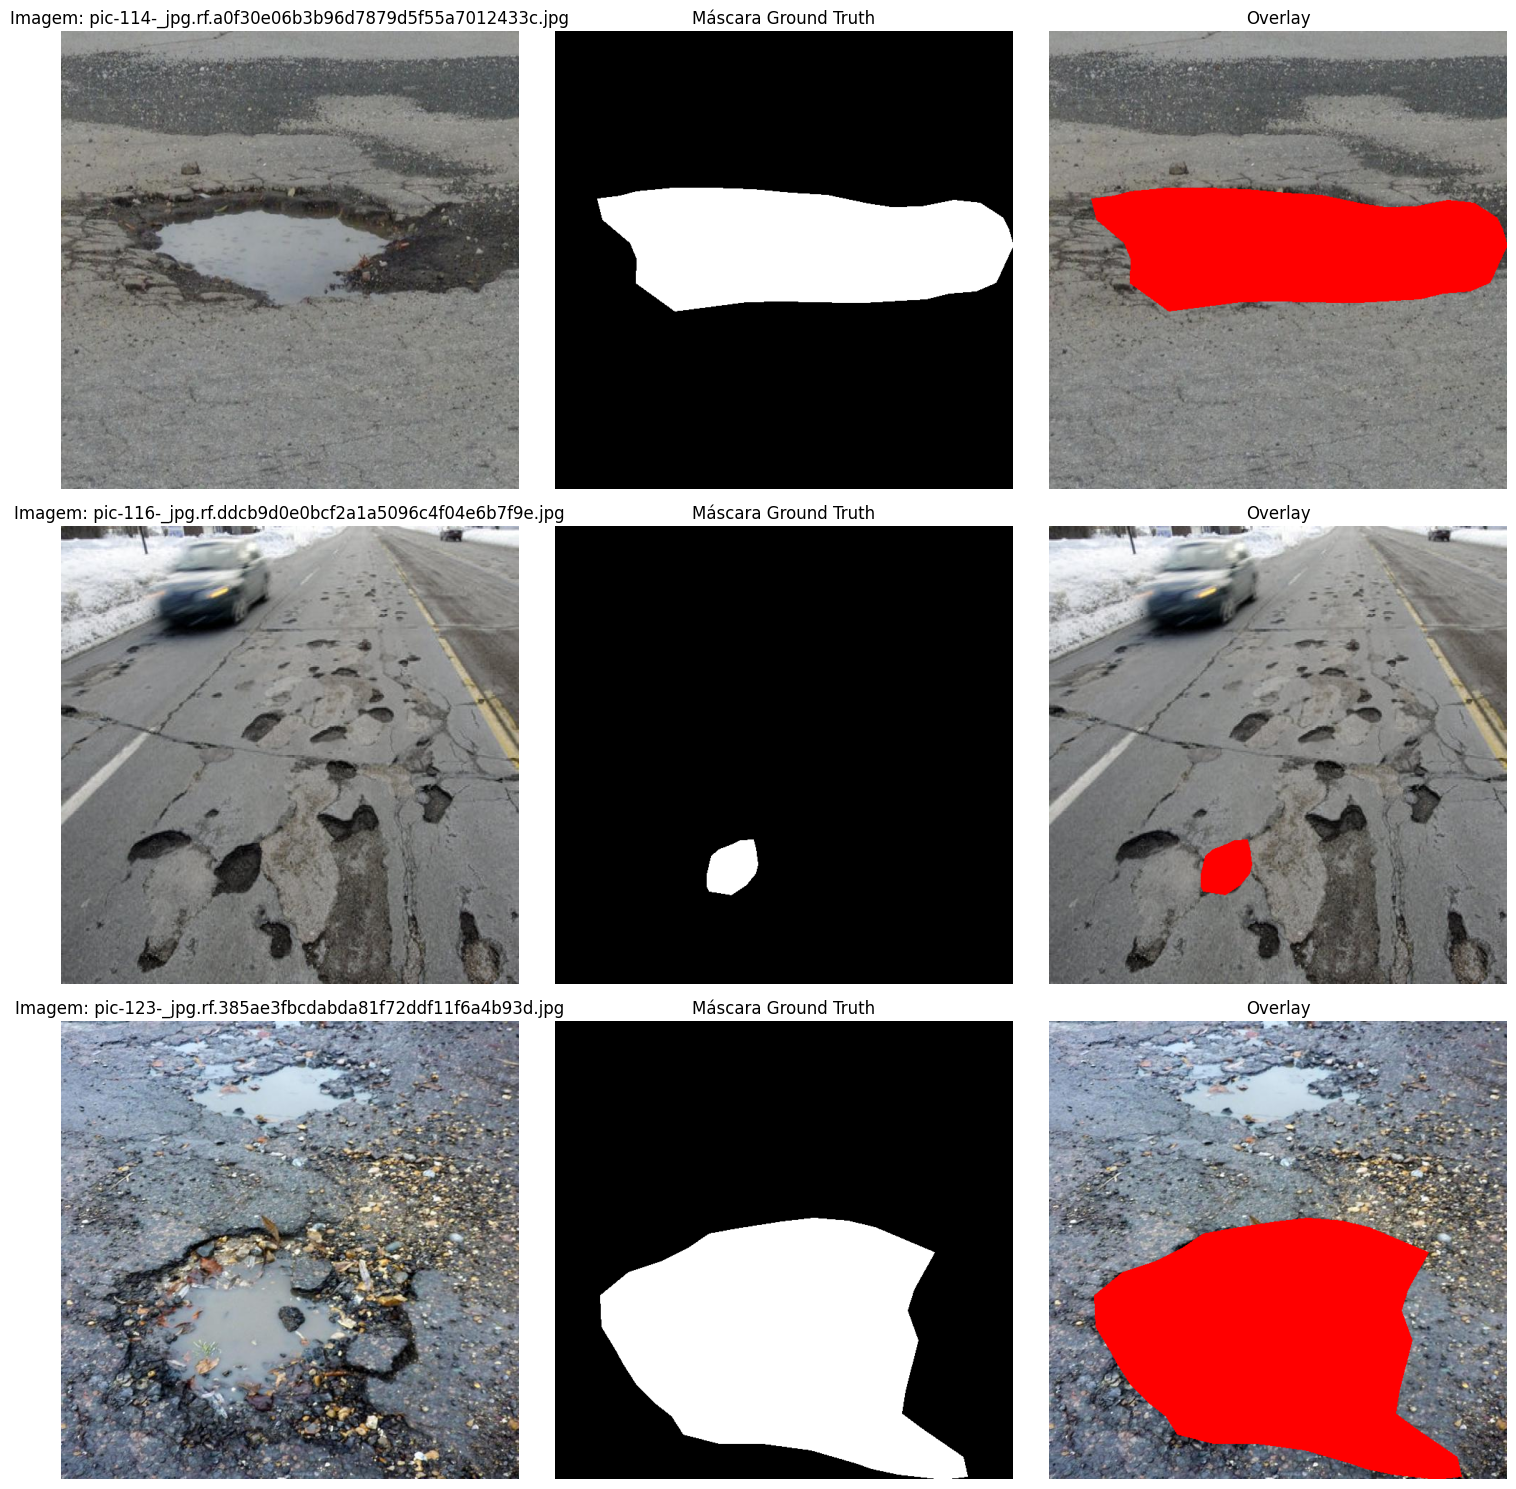

In [8]:
# Visualizar alguns exemplos do dataset
def visualize_samples(dataset, num_samples=3):
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

    for i in range(num_samples):
        sample = dataset[i]
        image = sample['image']
        mask = sample['mask']

        # Imagem original
        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f"Imagem: {sample['filename']}")
        axes[i, 0].axis('off')

        # Máscara ground truth
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title("Máscara Ground Truth")
        axes[i, 1].axis('off')

        # Overlay
        overlay = image.copy()
        overlay[mask == 1] = [255, 0, 0]  # Vermelho para buracos
        axes[i, 2].imshow(overlay)
        axes[i, 2].set_title("Overlay")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

visualize_samples(val_dataset, num_samples=3)

## Métricas de Avaliação

Vamos implementar as métricas IoU (Intersection over Union) e Dice Coefficient para avaliar o desempenho do modelo.

In [9]:
# Funções para calcular métricas
def calculate_iou(pred_mask, gt_mask):
    """Calcula Intersection over Union (IoU)"""
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()

    if union == 0:
        return 1.0 if intersection == 0 else 0.0

    return intersection / union

def calculate_dice(pred_mask, gt_mask):
    """Calcula Dice Coefficient"""
    intersection = np.logical_and(pred_mask, gt_mask).sum()

    if pred_mask.sum() + gt_mask.sum() == 0:
        return 1.0

    return 2 * intersection / (pred_mask.sum() + gt_mask.sum())

def calculate_metrics(pred_mask, gt_mask):
    """Calcula todas as métricas"""
    return {
        'iou': calculate_iou(pred_mask, gt_mask),
        'dice': calculate_dice(pred_mask, gt_mask)
    }

## Parte 1: Avaliação do SAM Pré-treinado (SEM Fine-tuning)

Vamos primeiro avaliar o modelo SAM original sem qualquer ajuste específico para nossa tarefa.

In [10]:
# Baixar e carregar o modelo SAM pré-treinado
# Primeiro, precisamos baixar os pesos do modelo
# Você pode escolher entre diferentes versões: vit_h, vit_l, vit_b

# Download do checkpoint (execute uma vez)
import urllib.request

checkpoint_url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
checkpoint_path = "sam_vit_h_4b8939.pth"

if not os.path.exists(checkpoint_path):
    print("Baixando checkpoint do SAM...")
    urllib.request.urlretrieve(checkpoint_url, checkpoint_path)
    print("Download concluído!")
else:
    print("Checkpoint já existe!")

Baixando checkpoint do SAM...
Download concluído!


In [11]:
# Carregar o modelo SAM
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam_pretrained = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam_pretrained.to(device=device)
sam_pretrained.eval()

print(f"Modelo SAM carregado com sucesso em {device}!")

Modelo SAM carregado com sucesso em cuda!


In [12]:
# Função para obter bounding box a partir da máscara ground truth
def get_bbox_from_mask(mask):
    """Extrai bounding box da máscara ground truth para usar como prompt"""
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)

    if not rows.any() or not cols.any():
        return None

    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return np.array([cmin, rmin, cmax, rmax])  # formato [x1, y1, x2, y2]

def get_center_point_from_mask(mask):
    """Extrai ponto central da máscara ground truth para usar como prompt"""
    rows, cols = np.where(mask > 0)

    if len(rows) == 0:
        return None

    center_y = int(np.mean(rows))
    center_x = int(np.mean(cols))

    return np.array([[center_x, center_y]])  # formato [[x, y]]

In [13]:
# Avaliar o modelo pré-treinado no dataset de validação
def evaluate_sam_pretrained(model, dataset, use_bbox=True, num_samples=None):
    """
    Avalia o SAM pré-treinado

    Args:
        model: Modelo SAM
        dataset: Dataset de validação
        use_bbox: Se True, usa bounding box como prompt. Se False, usa ponto central
        num_samples: Número de amostras para avaliar (None = todas)
    """
    predictor = SamPredictor(model)

    metrics_list = []
    results = []

    n_samples = len(dataset) if num_samples is None else min(num_samples, len(dataset))

    print(f"Avaliando {n_samples} amostras com prompt={'bbox' if use_bbox else 'point'}...")

    for i in tqdm(range(n_samples)):
        sample = dataset[i]
        image = sample['image']
        gt_mask = sample['mask']

        # Configurar a imagem no predictor
        predictor.set_image(image)

        if use_bbox:
            # Usar bounding box como prompt
            bbox = get_bbox_from_mask(gt_mask)
            if bbox is None:
                continue

            masks, scores, logits = predictor.predict(
                box=bbox,
                multimask_output=False
            )
        else:
            # Usar ponto central como prompt
            point = get_center_point_from_mask(gt_mask)
            if point is None:
                continue

            point_labels = np.array([1])  # 1 = ponto positivo (dentro do objeto)

            masks, scores, logits = predictor.predict(
                point_coords=point,
                point_labels=point_labels,
                multimask_output=False
            )

        # Pegar a melhor máscara
        pred_mask = masks[0]

        # Calcular métricas
        metrics = calculate_metrics(pred_mask, gt_mask)
        metrics_list.append(metrics)

        # Guardar resultados para visualização
        results.append({
            'image': image,
            'gt_mask': gt_mask,
            'pred_mask': pred_mask,
            'metrics': metrics,
            'filename': sample['filename']
        })

    # Calcular médias
    avg_metrics = {
        'iou': np.mean([m['iou'] for m in metrics_list]),
        'dice': np.mean([m['dice'] for m in metrics_list])
    }

    return avg_metrics, results

# Avaliar com bounding box prompt
print("\n=== Avaliação SAM Pré-treinado com BBOX Prompt ===")
metrics_bbox, results_bbox = evaluate_sam_pretrained(
    sam_pretrained,
    val_dataset,
    use_bbox=True,
    num_samples=50  # Ajuste conforme necessário
)

print(f"\nResultados com BBOX prompt:")
print(f"IoU médio: {metrics_bbox['iou']:.4f}")
print(f"Dice médio: {metrics_bbox['dice']:.4f}")

# Avaliar com point prompt
print("\n=== Avaliação SAM Pré-treinado com POINT Prompt ===")
metrics_point, results_point = evaluate_sam_pretrained(
    sam_pretrained,
    val_dataset,
    use_bbox=False,
    num_samples=50
)

print(f"\nResultados com POINT prompt:")
print(f"IoU médio: {metrics_point['iou']:.4f}")
print(f"Dice médio: {metrics_point['dice']:.4f}")


=== Avaliação SAM Pré-treinado com BBOX Prompt ===
Avaliando 50 amostras com prompt=bbox...


100%|██████████| 50/50 [01:46<00:00,  2.13s/it]



Resultados com BBOX prompt:
IoU médio: 0.7133
Dice médio: 0.8238

=== Avaliação SAM Pré-treinado com POINT Prompt ===
Avaliando 50 amostras com prompt=point...


100%|██████████| 50/50 [01:50<00:00,  2.21s/it]


Resultados com POINT prompt:
IoU médio: 0.4661
Dice médio: 0.5803


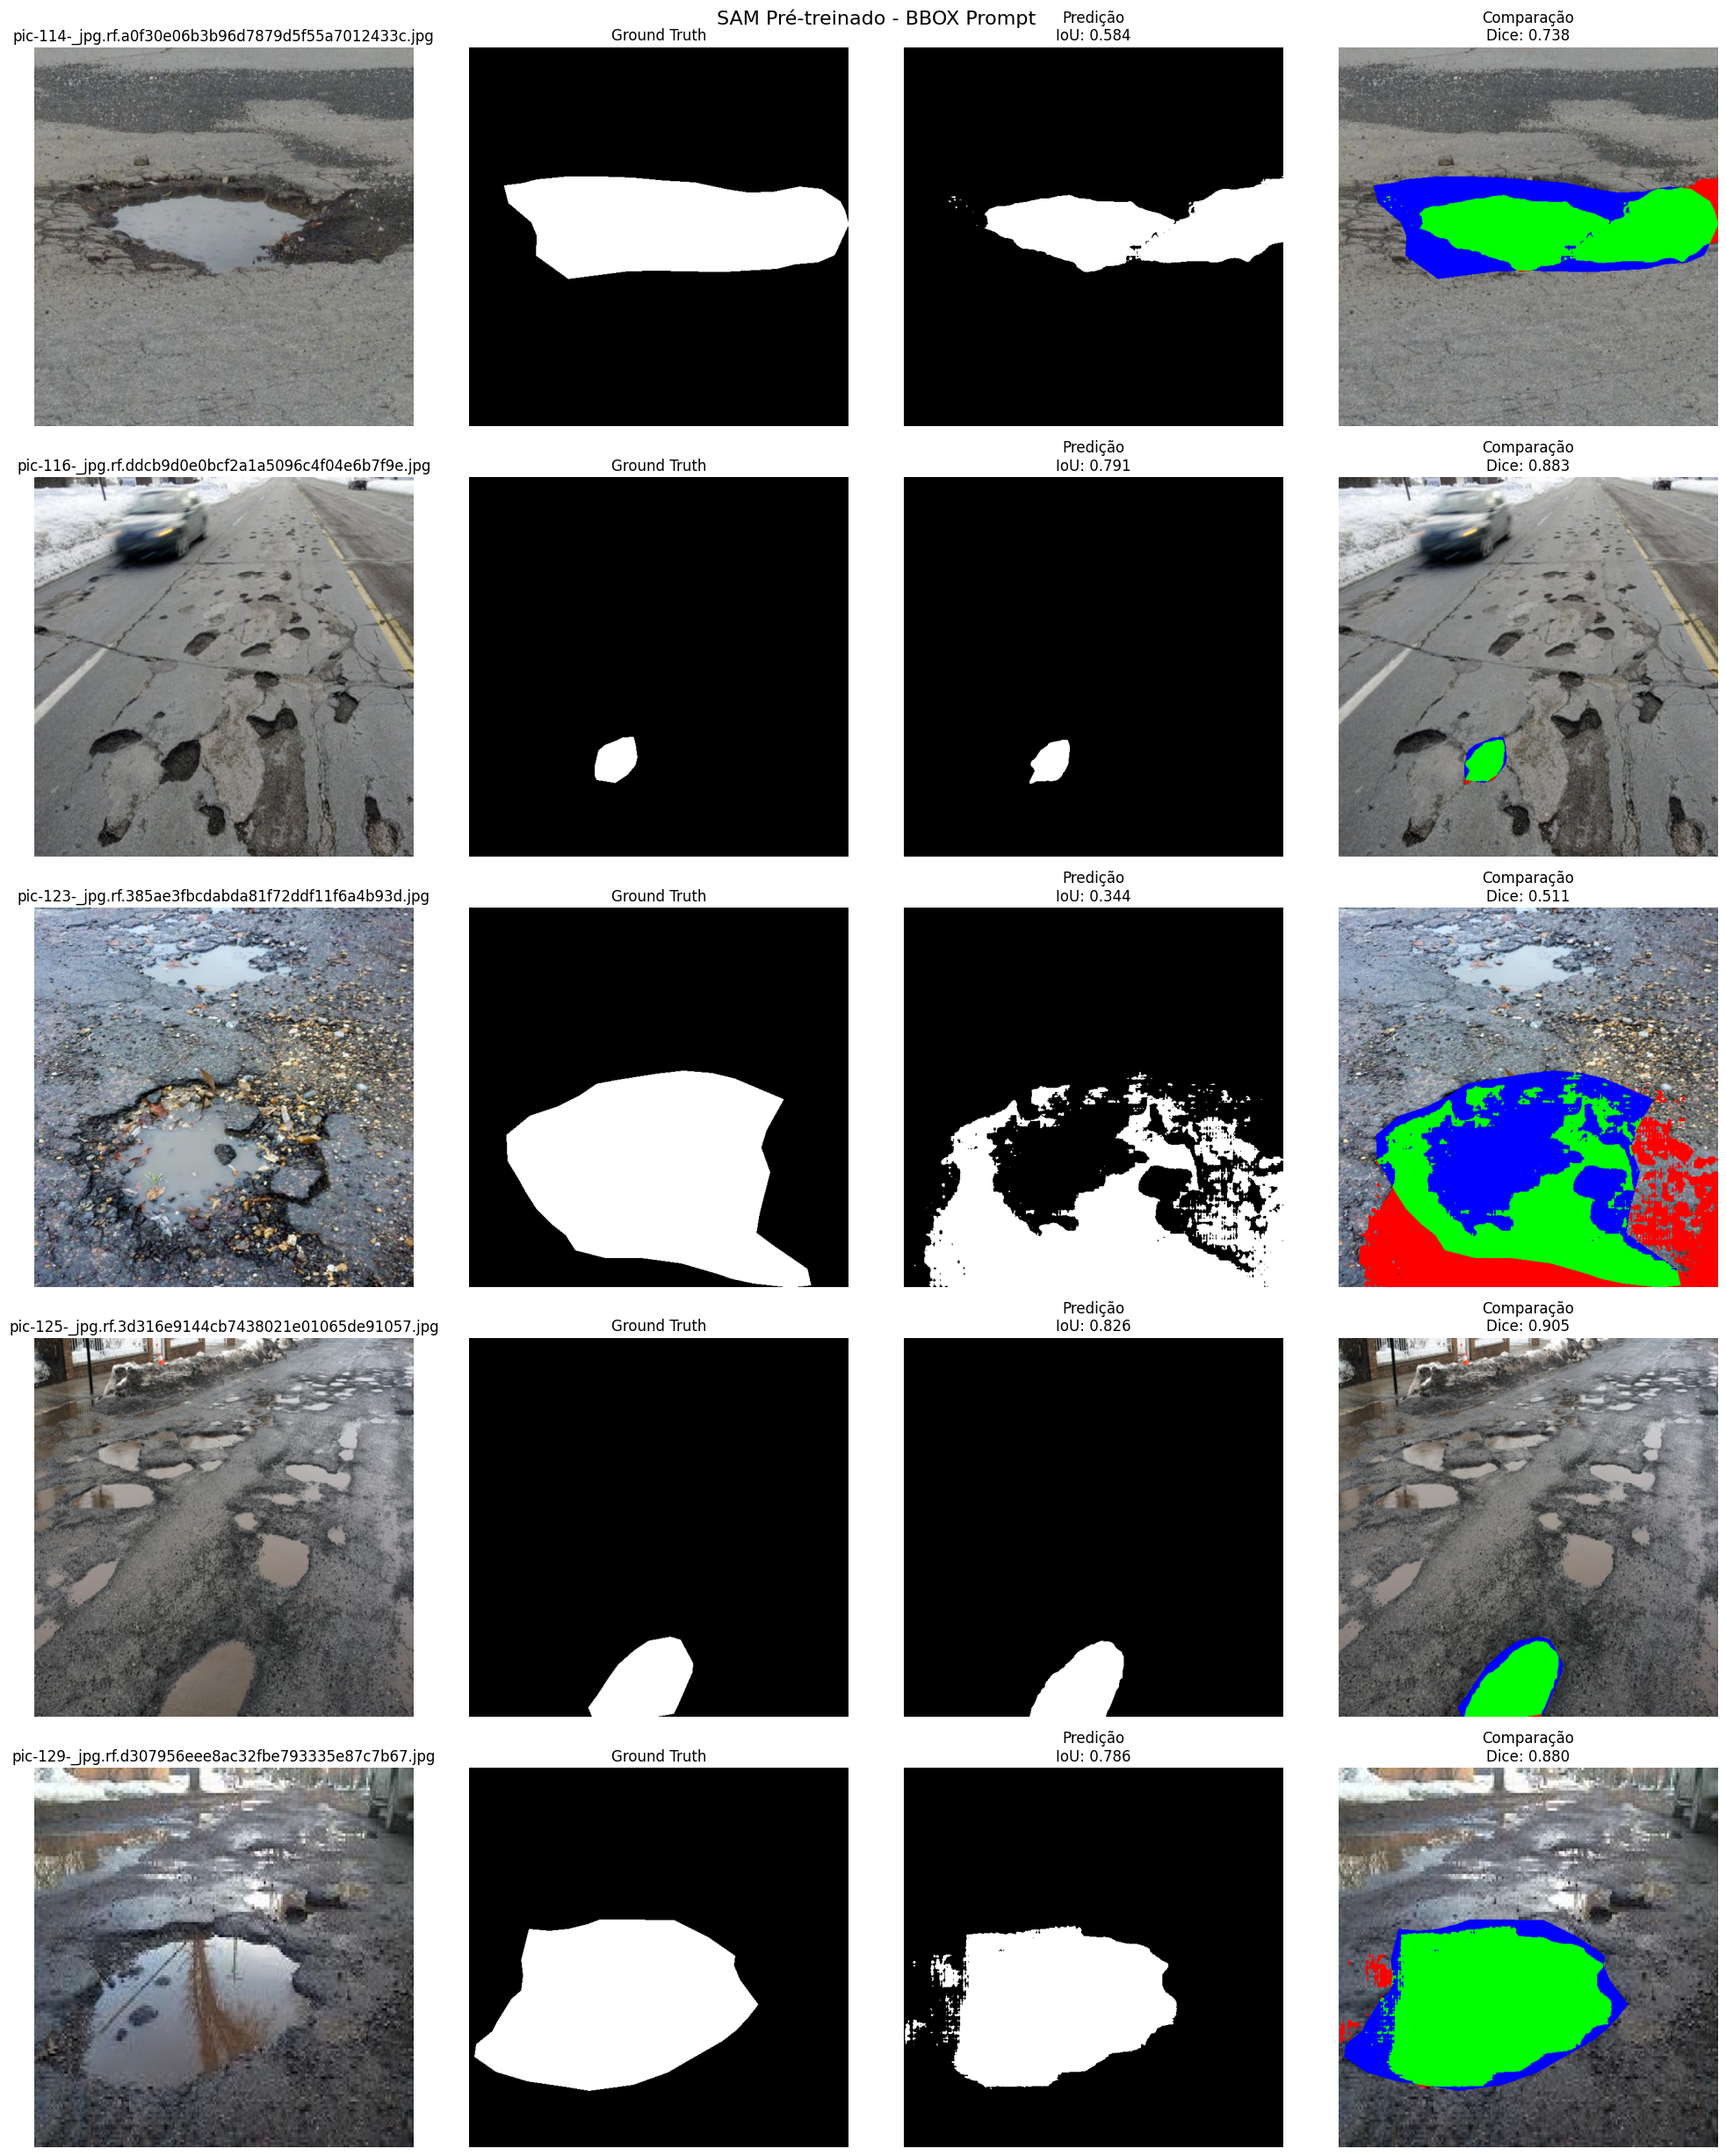

In [14]:
# Visualizar resultados do modelo pré-treinado
def visualize_results(results, num_samples=5, title="Resultados"):
    """Visualiza predições comparadas com ground truth"""
    n = min(num_samples, len(results))
    fig, axes = plt.subplots(n, 4, figsize=(20, 5*n))

    if n == 1:
        axes = axes.reshape(1, -1)

    for i in range(n):
        result = results[i]
        image = result['image']
        gt_mask = result['gt_mask']
        pred_mask = result['pred_mask']
        metrics = result['metrics']

        # Imagem original
        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f"{result['filename']}")
        axes[i, 0].axis('off')

        # Ground truth
        axes[i, 1].imshow(gt_mask, cmap='gray')
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis('off')

        # Predição
        axes[i, 2].imshow(pred_mask, cmap='gray')
        axes[i, 2].set_title(f"Predição\nIoU: {metrics['iou']:.3f}")
        axes[i, 2].axis('off')

        # Overlay de comparação
        overlay = image.copy()
        # Verde = True Positive, Vermelho = False Positive, Azul = False Negative
        tp = np.logical_and(pred_mask, gt_mask)
        fp = np.logical_and(pred_mask, np.logical_not(gt_mask))
        fn = np.logical_and(np.logical_not(pred_mask), gt_mask)

        overlay[tp] = [0, 255, 0]  # Verde
        overlay[fp] = [255, 0, 0]  # Vermelho
        overlay[fn] = [0, 0, 255]  # Azul

        axes[i, 3].imshow(overlay)
        axes[i, 3].set_title(f"Comparação\nDice: {metrics['dice']:.3f}")
        axes[i, 3].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualizar resultados com bbox
visualize_results(results_bbox, num_samples=5, title="SAM Pré-treinado - BBOX Prompt")

## Parte 2: Fine-tuning do SAM

Agora vamos realizar o fine-tuning do SAM especificamente para a tarefa de segmentação de buracos em ruas.

In [15]:
# Preparar o modelo para fine-tuning
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader
from segment_anything.utils.transforms import ResizeLongestSide

# Criar uma cópia do modelo para fine-tuning
sam_finetuned = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam_finetuned.to(device=device)
sam_finetuned.train()

# Congelar o image encoder (opcional - pode experimentar descongelar)
for param in sam_finetuned.image_encoder.parameters():
    param.requires_grad = False

# Manter o mask decoder e prompt encoder treináveis
for param in sam_finetuned.mask_decoder.parameters():
    param.requires_grad = True

for param in sam_finetuned.prompt_encoder.parameters():
    param.requires_grad = True

# Configurar otimizador e loss
optimizer = Adam(sam_finetuned.mask_decoder.parameters(), lr=1e-5)
loss_fn = BCEWithLogitsLoss()

print("Modelo preparado para fine-tuning!")
print(f"Parâmetros treináveis: {sum(p.numel() for p in sam_finetuned.parameters() if p.requires_grad):,}")

Modelo preparado para fine-tuning!
Parâmetros treináveis: 4,064,560


In [18]:
# Função de treinamento
def train_sam(model, train_dataset, val_dataset, num_epochs=10, batch_size=1):
    """
    Treina o modelo SAM
    """
    transform = ResizeLongestSide(model.image_encoder.img_size)

    train_losses = []
    val_metrics = []

    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []

        print(f"\nÉpoca {epoch+1}/{num_epochs}")

        # Embaralhar índices de treino
        indices = np.random.permutation(len(train_dataset))

        for idx in tqdm(indices, desc="Treinando"):
            sample = train_dataset[idx]
            image = sample['image']
            gt_mask = sample['mask']

            # Pular se não houver máscara
            if gt_mask.sum() == 0:
                continue

            # Preparar imagem
            input_image = transform.apply_image(image)
            # Converter para float e normalizar (SAM espera entradas entre 0 e 255, mas em float)
            input_image_torch = torch.as_tensor(input_image, device=device, dtype=torch.float32)
            input_image_torch = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

            # Preparar máscara
            # A máscara também precisa ser float32 para o cálculo do loss
            input_mask = transform.apply_image(gt_mask[:, :, None])
            input_mask = torch.as_tensor(input_mask, device=device, dtype=torch.float32).squeeze()

            # Obter embeddings da imagem
            with torch.no_grad():
                image_embedding = model.image_encoder(input_image_torch)

            # Usar bounding box como prompt
            bbox = get_bbox_from_mask(gt_mask)
            if bbox is None:
                continue

            # Transformar bbox para o tamanho da imagem processada
            bbox_transformed = transform.apply_boxes(bbox[None, :], image.shape[:2])
            bbox_torch = torch.as_tensor(bbox_transformed, dtype=torch.float, device=device)

            # Fazer predição
            sparse_embeddings, dense_embeddings = model.prompt_encoder(
                points=None,
                boxes=bbox_torch,
                masks=None,
            )

            low_res_masks, iou_predictions = model.mask_decoder(
                image_embeddings=image_embedding,
                image_pe=model.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=False,
            )

            # Redimensionar máscara de saída para comparar com ground truth
            upscaled_masks = model.postprocess_masks(
                low_res_masks,
                input_size=(input_image.shape[0], input_image.shape[1]),
                original_size=image.shape[:2]
            )

            # Calcular loss
            # gt_mask_torch também deve ser float32
            gt_mask_torch = torch.as_tensor(gt_mask, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)
            loss = loss_fn(upscaled_masks, gt_mask_torch)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        # Calcular loss médio da época
        avg_loss = np.mean(epoch_losses)
        train_losses.append(avg_loss)

        print(f"Loss médio: {avg_loss:.4f}")

        # Validação
        model.eval()
        val_iou_list = []
        val_dice_list = []

        with torch.no_grad():
            for i in range(min(20, len(val_dataset))):  # Validar em subset
                sample = val_dataset[i]
                image = sample['image']
                gt_mask = sample['mask']

                if gt_mask.sum() == 0:
                    continue

                # Preparar imagem
                input_image = transform.apply_image(image)
                input_image_torch = torch.as_tensor(input_image, device=device, dtype=torch.float32)
                input_image_torch = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

                # Embeddings
                image_embedding = model.image_encoder(input_image_torch)

                # Prompt
                bbox = get_bbox_from_mask(gt_mask)
                if bbox is None:
                    continue

                bbox_transformed = transform.apply_boxes(bbox[None, :], image.shape[:2])
                bbox_torch = torch.as_tensor(bbox_transformed, dtype=torch.float, device=device)

                # Predição
                sparse_embeddings, dense_embeddings = model.prompt_encoder(
                    points=None,
                    boxes=bbox_torch,
                    masks=None,
                )

                low_res_masks, _ = model.mask_decoder(
                    image_embeddings=image_embedding,
                    image_pe=model.prompt_encoder.get_dense_pe(),
                    sparse_prompt_embeddings=sparse_embeddings,
                    dense_prompt_embeddings=dense_embeddings,
                    multimask_output=False,
                )

                upscaled_masks = model.postprocess_masks(
                    low_res_masks,
                    input_size=(input_image.shape[0], input_image.shape[1]),
                    original_size=image.shape[:2]
                )

                # Converter para numpy
                pred_mask = (upscaled_masks[0, 0].cpu().numpy() > 0).astype(np.uint8)

                # Calcular métricas
                metrics = calculate_metrics(pred_mask, gt_mask)
                val_iou_list.append(metrics['iou'])
                val_dice_list.append(metrics['dice'])

        avg_val_iou = np.mean(val_iou_list) if val_iou_list else 0
        avg_val_dice = np.mean(val_dice_list) if val_dice_list else 0
        val_metrics.append({'iou': avg_val_iou, 'dice': avg_val_dice})

        print(f"Validação - IoU: {avg_val_iou:.4f}, Dice: {avg_val_dice:.4f}")

    return train_losses, val_metrics

# Executar treinamento
print("Iniciando fine-tuning...")
train_losses, val_metrics = train_sam(
    sam_finetuned,
    train_dataset,
    val_dataset,
    num_epochs=5,  # Ajuste conforme necessário
    batch_size=1
)

print("\nFine-tuning concluído!")

Iniciando fine-tuning...

Época 1/5


Treinando: 100%|██████████| 720/720 [26:49<00:00,  2.24s/it]


Loss médio: 0.1088
Validação - IoU: 0.7892, Dice: 0.8801

Época 2/5


Treinando: 100%|██████████| 720/720 [26:48<00:00,  2.23s/it]


Loss médio: 0.0916
Validação - IoU: 0.7909, Dice: 0.8808

Época 3/5


Treinando: 100%|██████████| 720/720 [26:45<00:00,  2.23s/it]


Loss médio: 0.0854
Validação - IoU: 0.8049, Dice: 0.8899

Época 4/5


Treinando: 100%|██████████| 720/720 [26:46<00:00,  2.23s/it]


Loss médio: 0.0797
Validação - IoU: 0.8097, Dice: 0.8930

Época 5/5


Treinando: 100%|██████████| 720/720 [26:48<00:00,  2.23s/it]


Loss médio: 0.0757
Validação - IoU: 0.8092, Dice: 0.8927

Fine-tuning concluído!


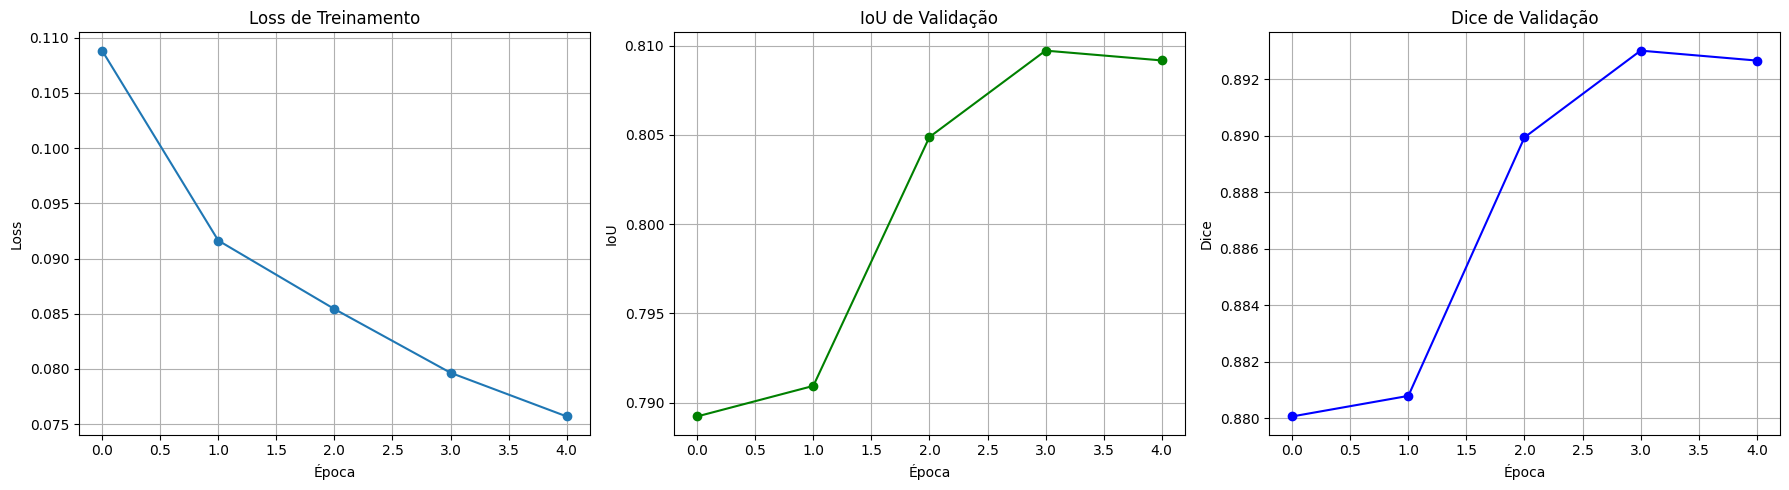

In [19]:
# Plotar curvas de treinamento
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss de treino
axes[0].plot(train_losses, marker='o')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss de Treinamento')
axes[0].grid(True)

# IoU de validação
iou_vals = [m['iou'] for m in val_metrics]
axes[1].plot(iou_vals, marker='o', color='green')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('IoU')
axes[1].set_title('IoU de Validação')
axes[1].grid(True)

# Dice de validação
dice_vals = [m['dice'] for m in val_metrics]
axes[2].plot(dice_vals, marker='o', color='blue')
axes[2].set_xlabel('Época')
axes[2].set_ylabel('Dice')
axes[2].set_title('Dice de Validação')
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [20]:
# Salvar o modelo fine-tuned
torch.save(sam_finetuned.state_dict(), 'sam_finetuned_streethole.pth')
print("Modelo fine-tuned salvo como 'sam_finetuned_streethole.pth'")

Modelo fine-tuned salvo como 'sam_finetuned_streethole.pth'


## Parte 3: Comparação Final - SAM Pré-treinado vs SAM Fine-tuned

In [21]:
# Avaliar o modelo fine-tuned no dataset completo de validação
print("\n=== Avaliação do SAM Fine-tuned ===")

sam_finetuned.eval()
metrics_finetuned, results_finetuned = evaluate_sam_pretrained(
    sam_finetuned,
    val_dataset,
    use_bbox=True,
    num_samples=50
)

print(f"\nResultados SAM Fine-tuned:")
print(f"IoU médio: {metrics_finetuned['iou']:.4f}")
print(f"Dice médio: {metrics_finetuned['dice']:.4f}")


=== Avaliação do SAM Fine-tuned ===
Avaliando 50 amostras com prompt=bbox...


100%|██████████| 50/50 [01:50<00:00,  2.22s/it]


Resultados SAM Fine-tuned:
IoU médio: 0.7711
Dice médio: 0.8649


In [22]:
# Comparação lado a lado
import pandas as pd

comparison_df = pd.DataFrame({
    'Modelo': ['SAM Pré-treinado (BBOX)', 'SAM Pré-treinado (Point)', 'SAM Fine-tuned'],
    'IoU': [metrics_bbox['iou'], metrics_point['iou'], metrics_finetuned['iou']],
    'Dice': [metrics_bbox['dice'], metrics_point['dice'], metrics_finetuned['dice']]
})

print("\n" + "="*60)
print("COMPARAÇÃO DE RESULTADOS")
print("="*60)
print(comparison_df.to_string(index=False))
print("="*60)

# Calcular melhorias
improvement_iou = ((metrics_finetuned['iou'] - metrics_bbox['iou']) / metrics_bbox['iou']) * 100
improvement_dice = ((metrics_finetuned['dice'] - metrics_bbox['dice']) / metrics_bbox['dice']) * 100

print(f"\nMelhoria com fine-tuning:")
print(f"  IoU: {improvement_iou:+.2f}%")
print(f"  Dice: {improvement_dice:+.2f}%")


COMPARAÇÃO DE RESULTADOS
                  Modelo      IoU     Dice
 SAM Pré-treinado (BBOX) 0.713300 0.823754
SAM Pré-treinado (Point) 0.466118 0.580300
          SAM Fine-tuned 0.771112 0.864874

Melhoria com fine-tuning:
  IoU: +8.10%
  Dice: +4.99%


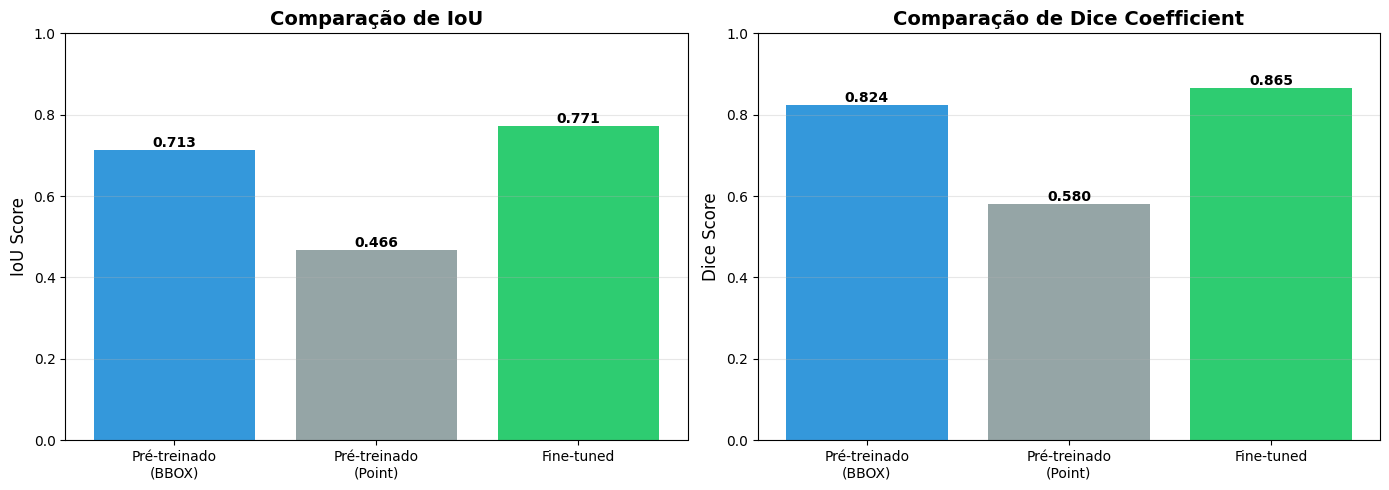

In [23]:
# Gráfico de barras comparativo
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models = ['Pré-treinado\n(BBOX)', 'Pré-treinado\n(Point)', 'Fine-tuned']
iou_scores = [metrics_bbox['iou'], metrics_point['iou'], metrics_finetuned['iou']]
dice_scores = [metrics_bbox['dice'], metrics_point['dice'], metrics_finetuned['dice']]

# IoU
bars1 = axes[0].bar(models, iou_scores, color=['#3498db', '#95a5a6', '#2ecc71'])
axes[0].set_ylabel('IoU Score', fontsize=12)
axes[0].set_title('Comparação de IoU', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontweight='bold')

# Dice
bars2 = axes[1].bar(models, dice_scores, color=['#3498db', '#95a5a6', '#2ecc71'])
axes[1].set_ylabel('Dice Score', fontsize=12)
axes[1].set_title('Comparação de Dice Coefficient', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

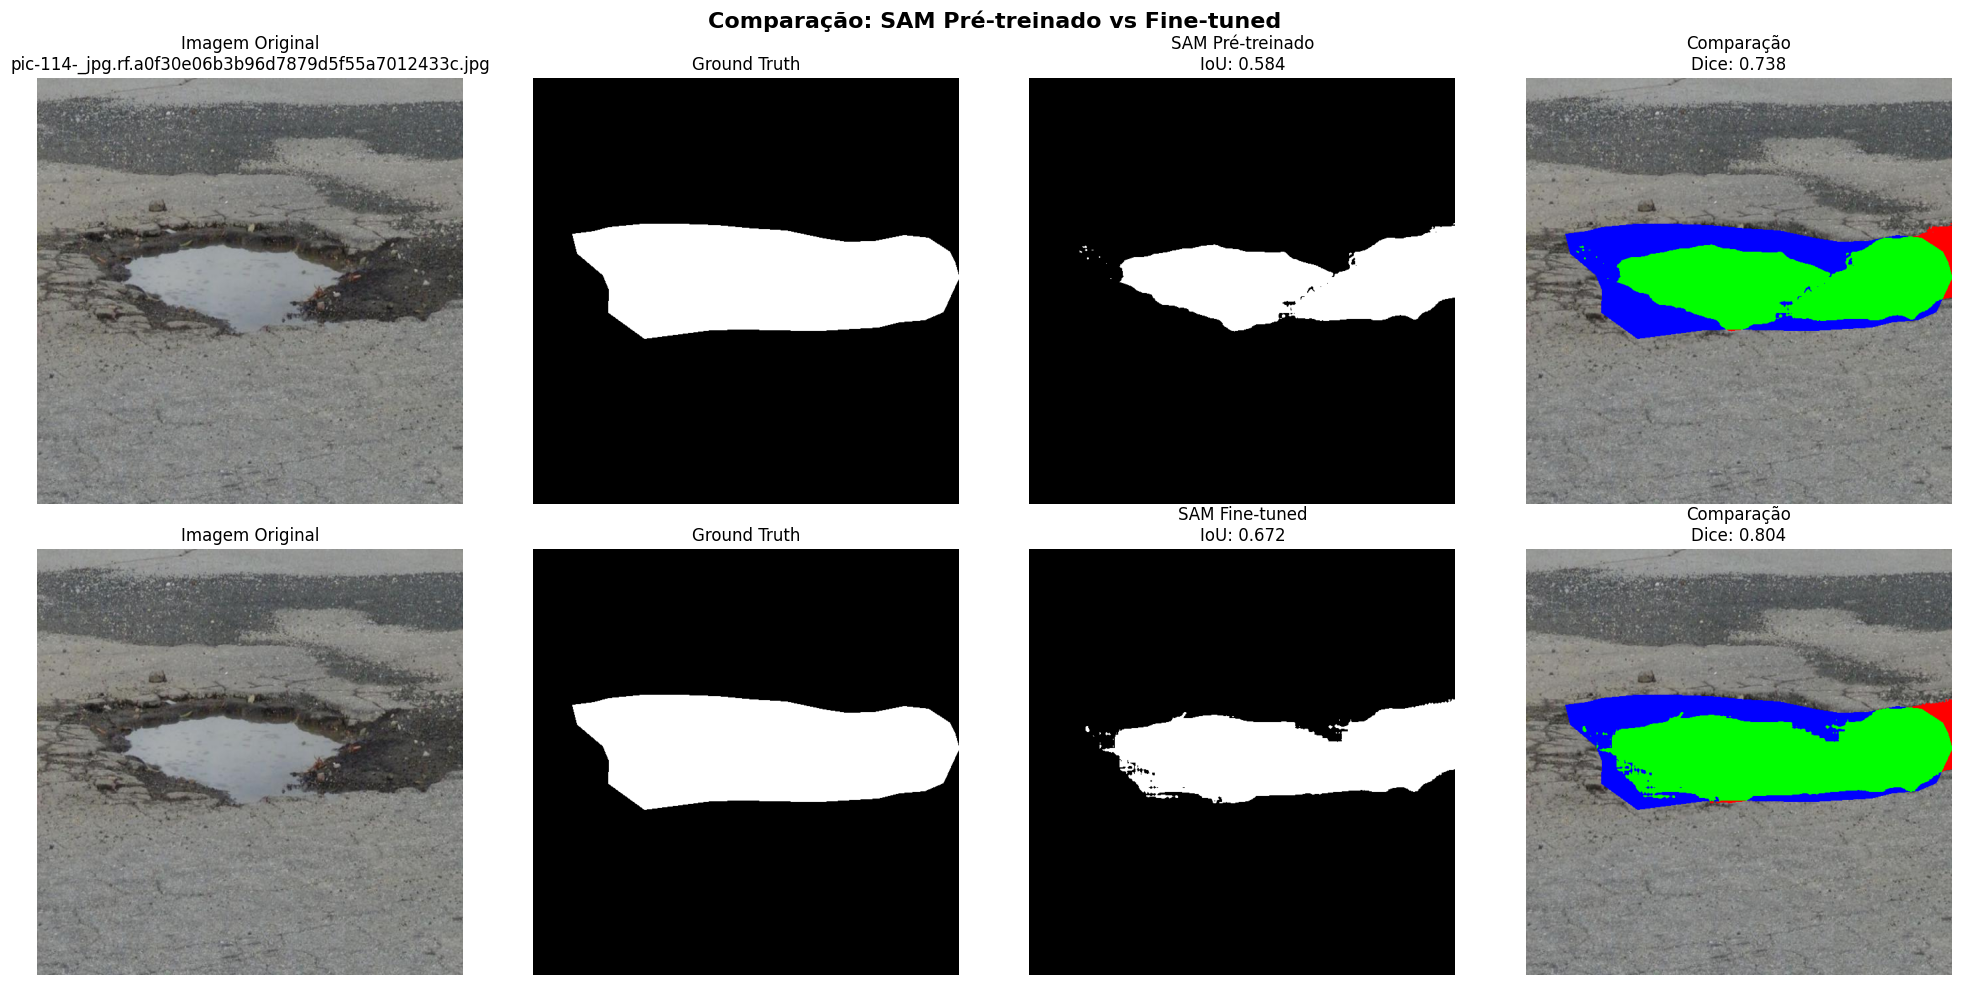

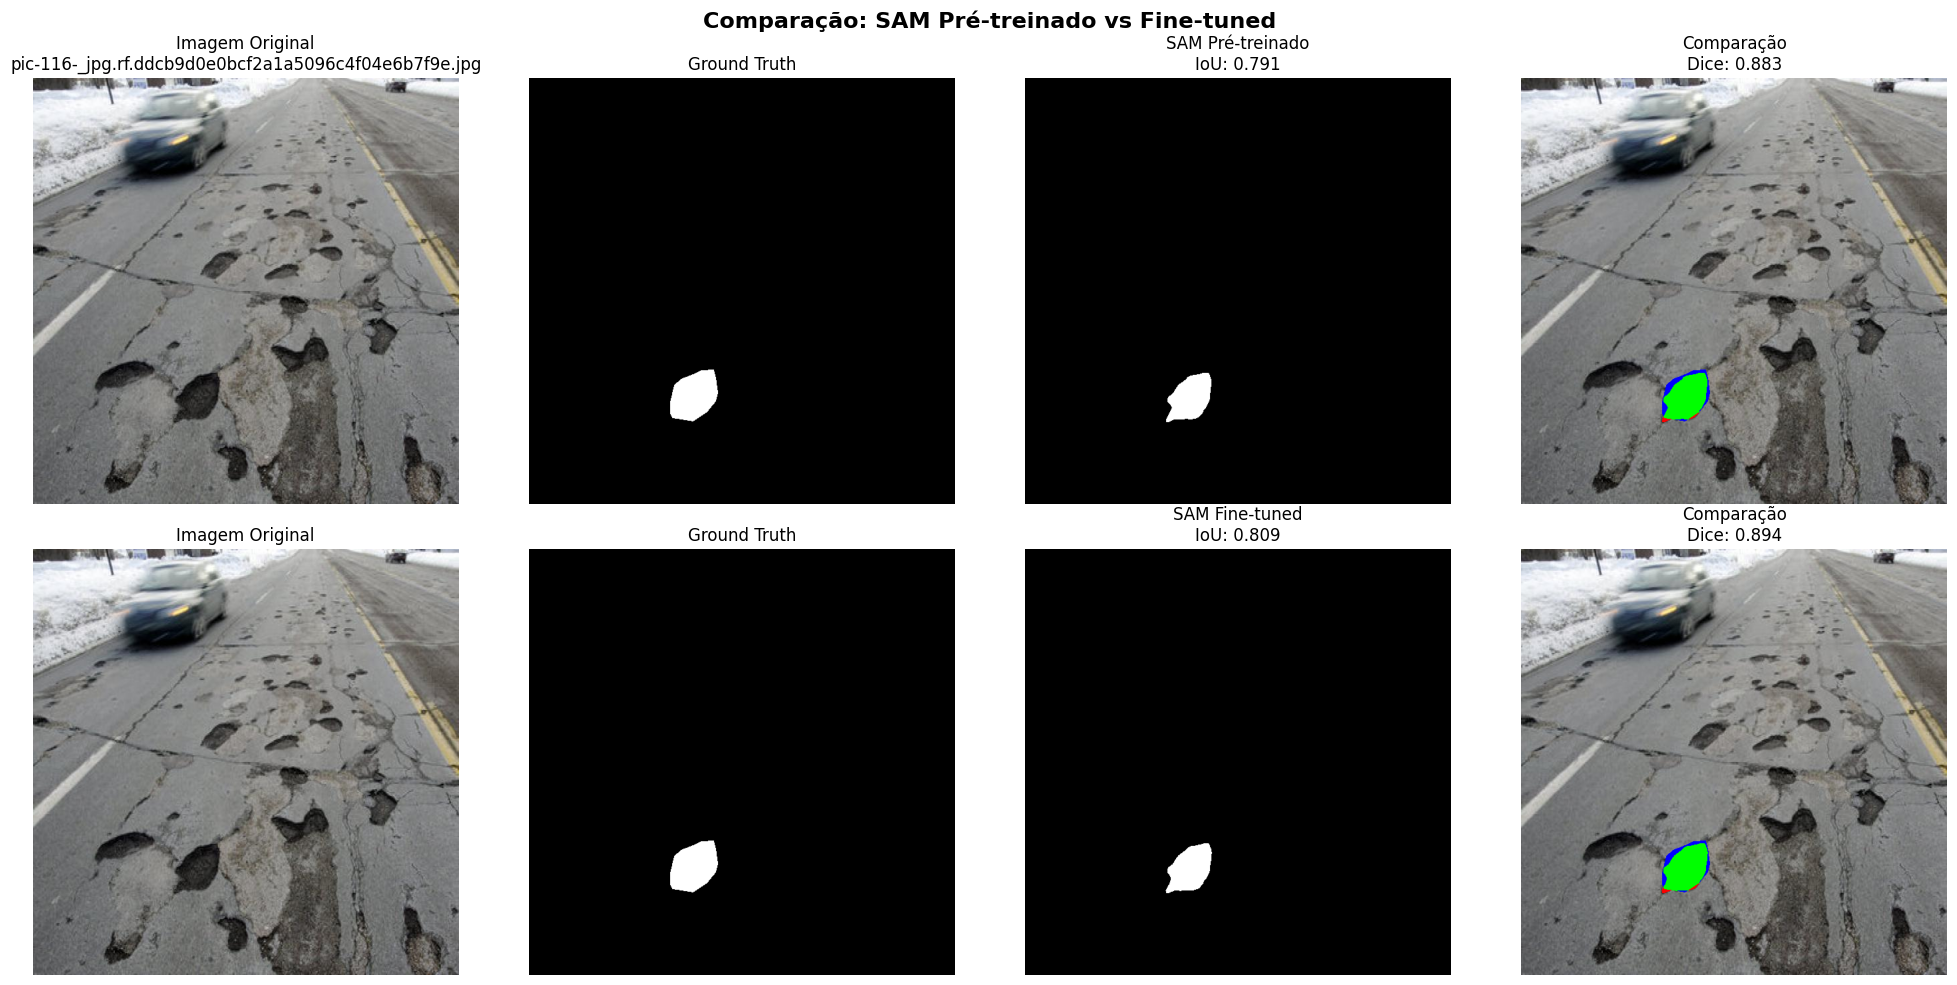

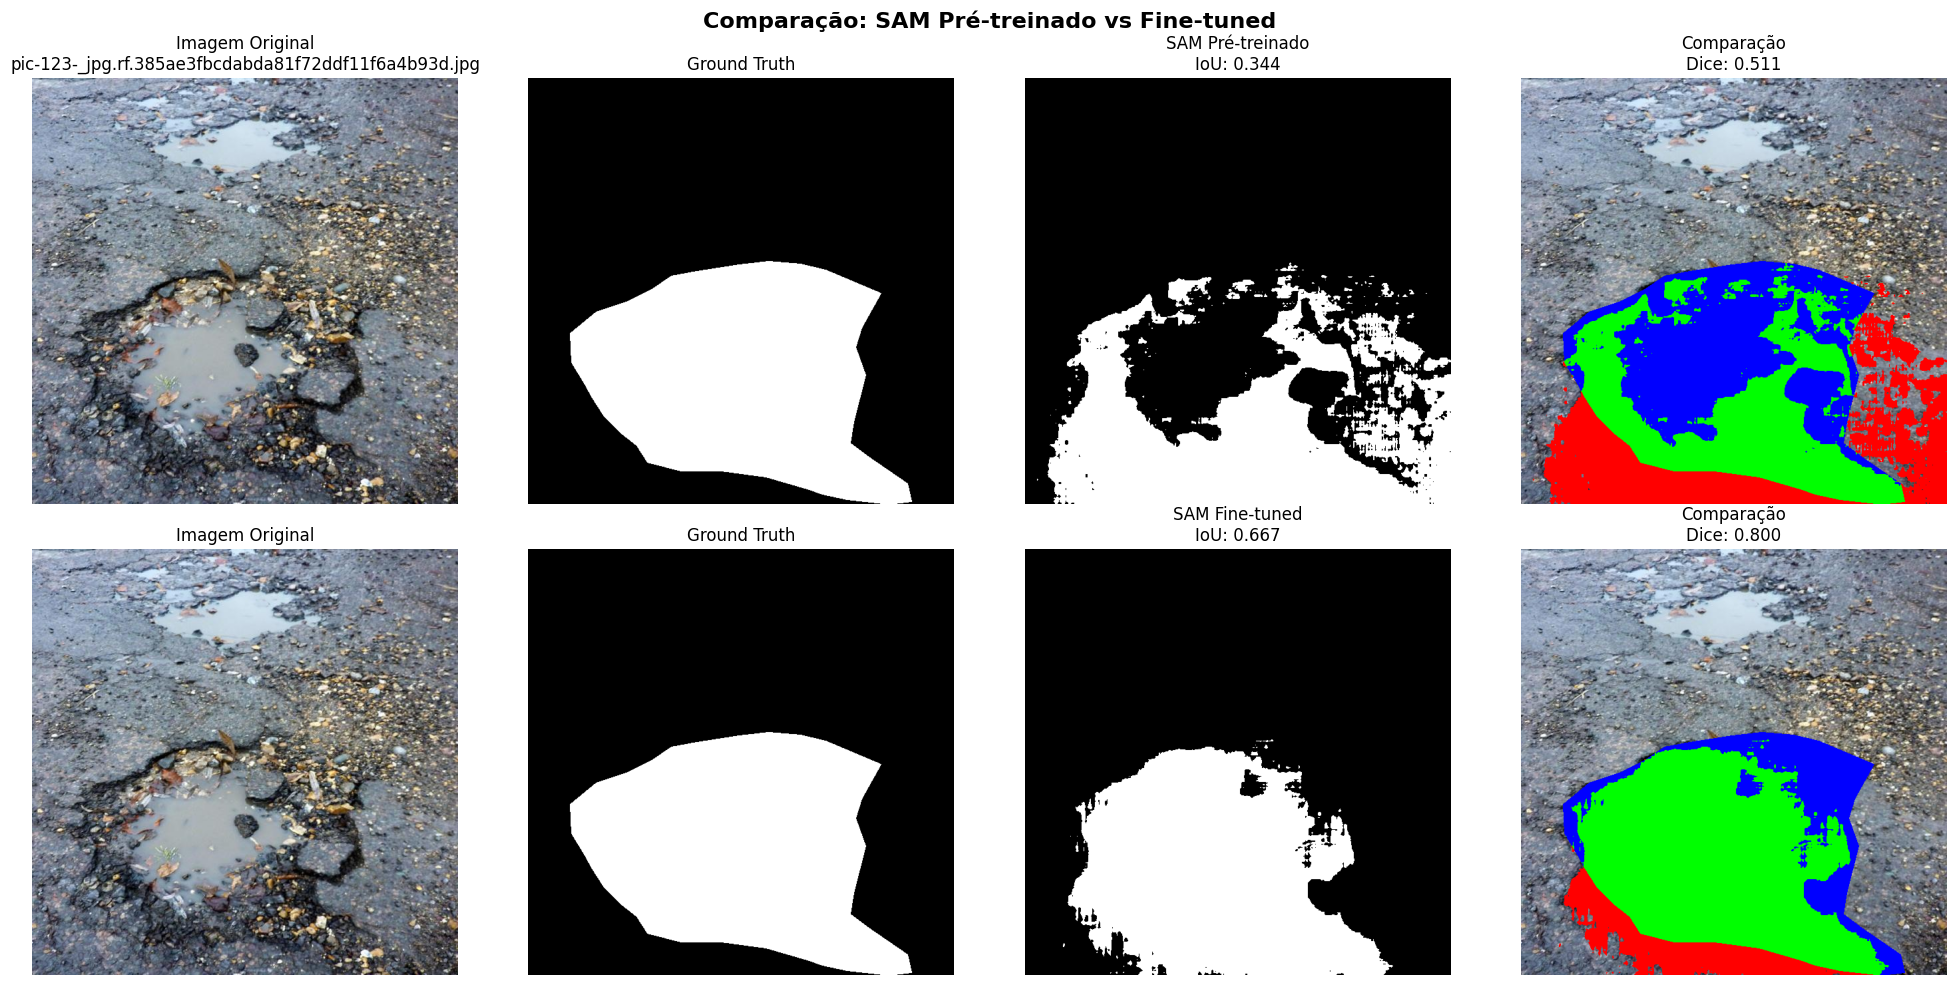

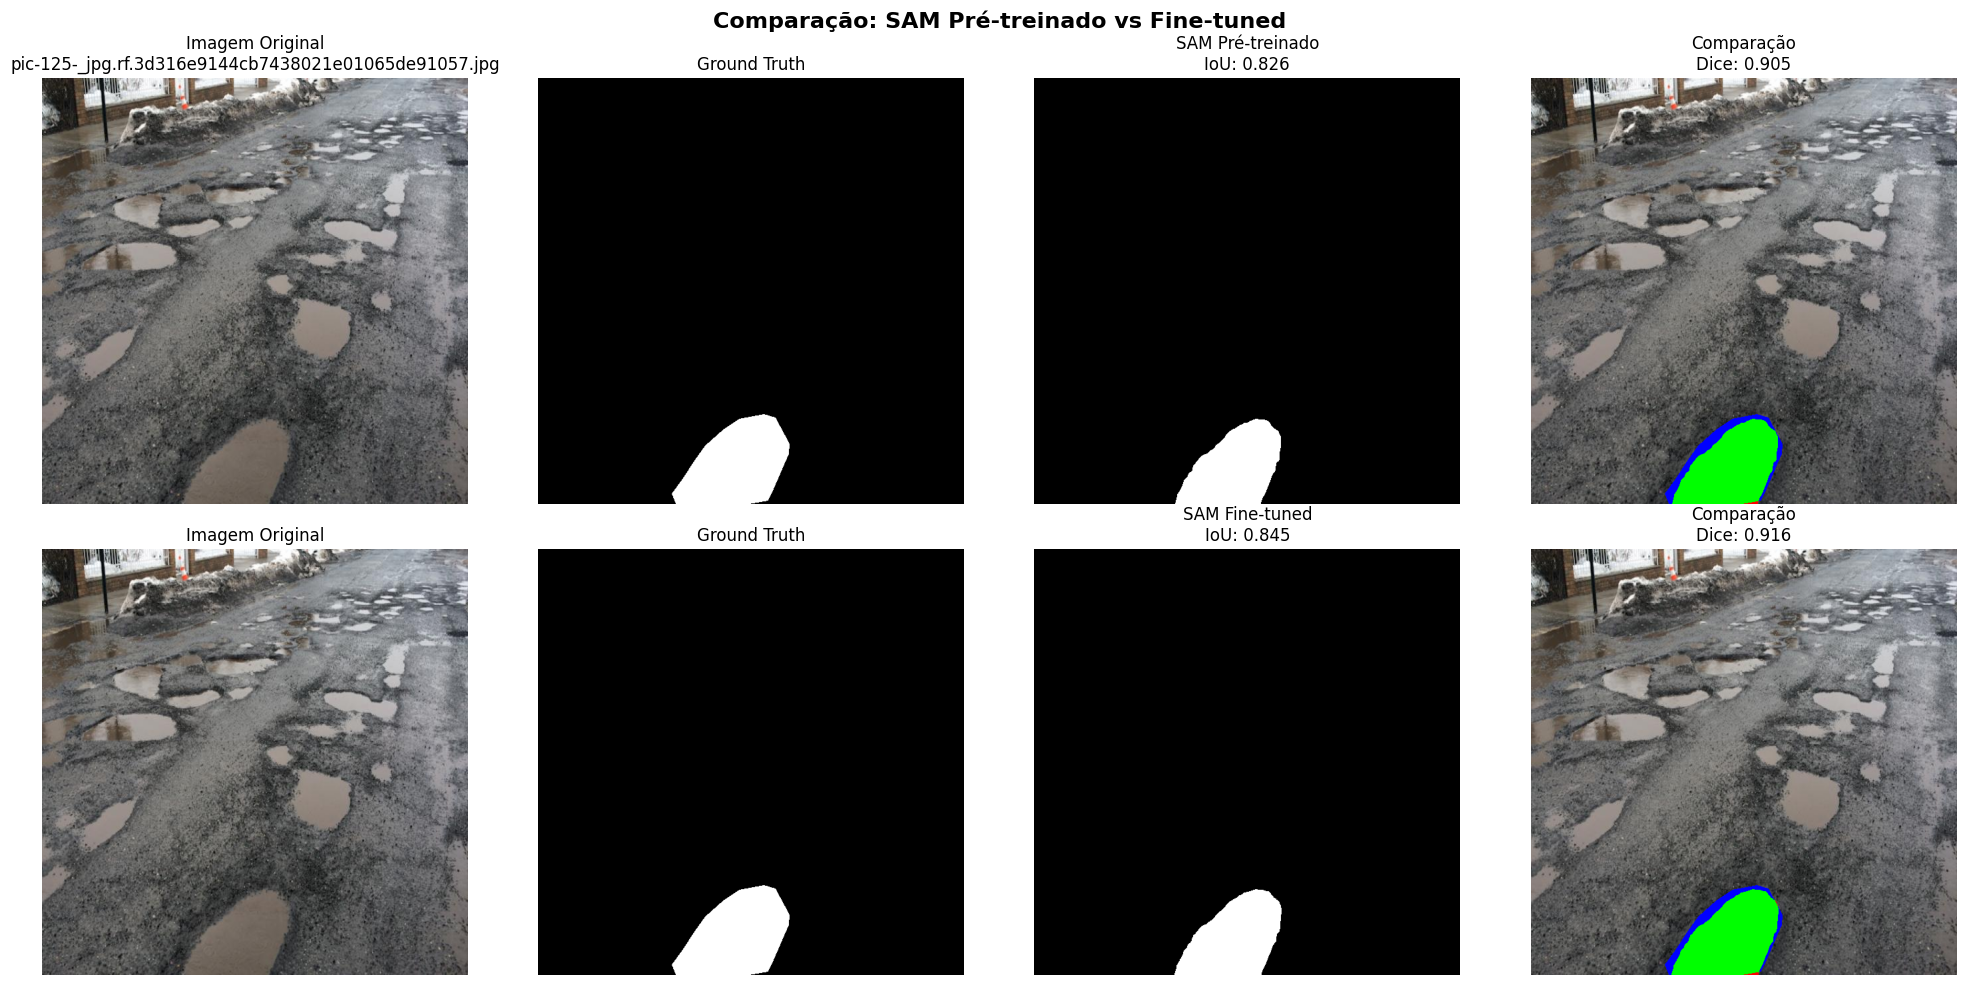

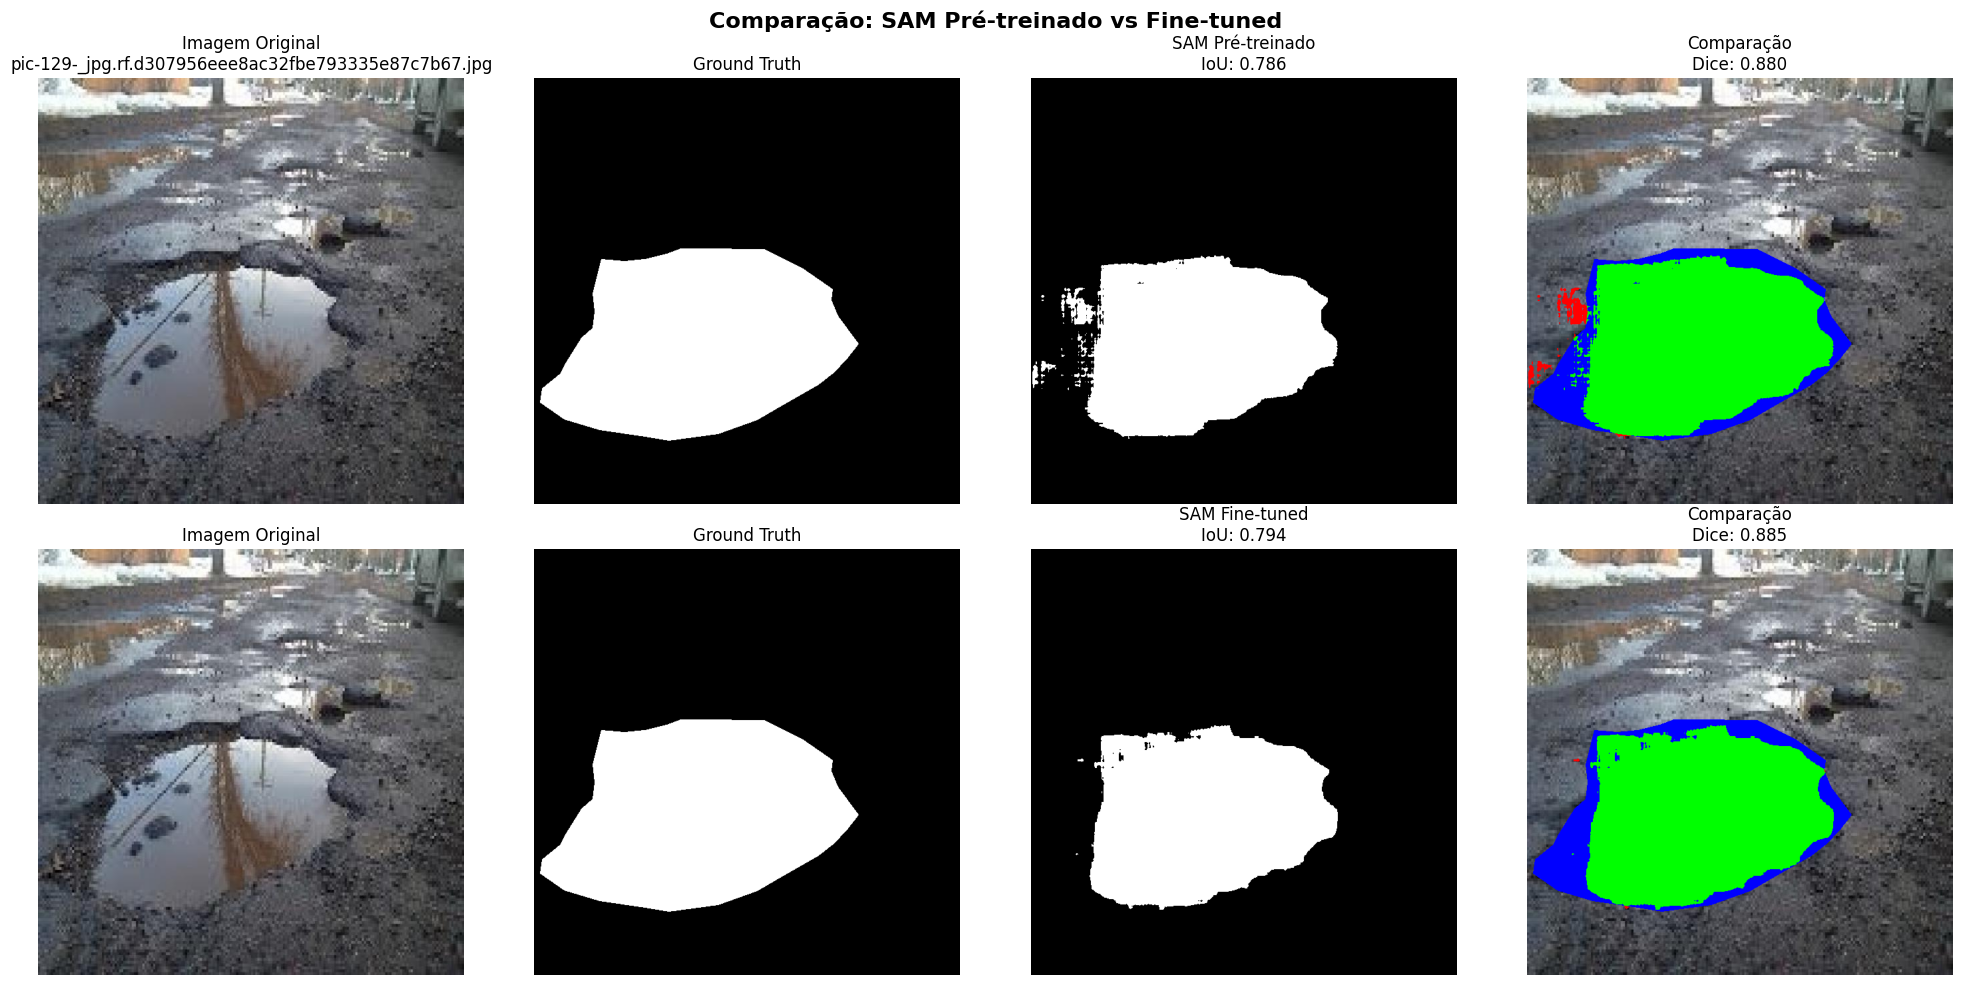

In [24]:
# Visualização comparativa
def visualize_comparison(idx, results_pretrained, results_finetuned):
    """Compara visualmente resultados do modelo pré-treinado vs fine-tuned"""

    result_pre = results_pretrained[idx]
    result_ft = results_finetuned[idx]

    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    # Linha 1: Pré-treinado
    axes[0, 0].imshow(result_pre['image'])
    axes[0, 0].set_title(f"Imagem Original\n{result_pre['filename']}")
    axes[0, 0].axis('off')

    axes[0, 1].imshow(result_pre['gt_mask'], cmap='gray')
    axes[0, 1].set_title("Ground Truth")
    axes[0, 1].axis('off')

    axes[0, 2].imshow(result_pre['pred_mask'], cmap='gray')
    axes[0, 2].set_title(f"SAM Pré-treinado\nIoU: {result_pre['metrics']['iou']:.3f}")
    axes[0, 2].axis('off')

    # Overlay pré-treinado
    overlay_pre = result_pre['image'].copy()
    tp = np.logical_and(result_pre['pred_mask'], result_pre['gt_mask'])
    fp = np.logical_and(result_pre['pred_mask'], np.logical_not(result_pre['gt_mask']))
    fn = np.logical_and(np.logical_not(result_pre['pred_mask']), result_pre['gt_mask'])
    overlay_pre[tp] = [0, 255, 0]
    overlay_pre[fp] = [255, 0, 0]
    overlay_pre[fn] = [0, 0, 255]
    axes[0, 3].imshow(overlay_pre)
    axes[0, 3].set_title(f"Comparação\nDice: {result_pre['metrics']['dice']:.3f}")
    axes[0, 3].axis('off')

    # Linha 2: Fine-tuned
    axes[1, 0].imshow(result_ft['image'])
    axes[1, 0].set_title("Imagem Original")
    axes[1, 0].axis('off')

    axes[1, 1].imshow(result_ft['gt_mask'], cmap='gray')
    axes[1, 1].set_title("Ground Truth")
    axes[1, 1].axis('off')

    axes[1, 2].imshow(result_ft['pred_mask'], cmap='gray')
    axes[1, 2].set_title(f"SAM Fine-tuned\nIoU: {result_ft['metrics']['iou']:.3f}")
    axes[1, 2].axis('off')

    # Overlay fine-tuned
    overlay_ft = result_ft['image'].copy()
    tp = np.logical_and(result_ft['pred_mask'], result_ft['gt_mask'])
    fp = np.logical_and(result_ft['pred_mask'], np.logical_not(result_ft['gt_mask']))
    fn = np.logical_and(np.logical_not(result_ft['pred_mask']), result_ft['gt_mask'])
    overlay_ft[tp] = [0, 255, 0]
    overlay_ft[fp] = [255, 0, 0]
    overlay_ft[fn] = [0, 0, 255]
    axes[1, 3].imshow(overlay_ft)
    axes[1, 3].set_title(f"Comparação\nDice: {result_ft['metrics']['dice']:.3f}")
    axes[1, 3].axis('off')

    plt.suptitle("Comparação: SAM Pré-treinado vs Fine-tuned", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualizar algumas comparações
for i in range(5):
    visualize_comparison(i, results_bbox, results_finetuned)